**Repository**: https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-ML-Models. 
<br><br>

### <font color= 'orange'> **S & P 500 Risk Optimized Portfolios ML Models (14 Apr $yr_{(2020-2023)}$)**<font> 

In [2]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as st
from scipy import optimize

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from yahoofinancials import YahooFinancials 
import datetime 
import time

from tabulate import tabulate
import IPython.display as d

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Function to get historical price data from yahoo_financials
def get_historical_price_data(ticker, years):
    """
    get_historical_price_data function downloads the historical price data of the stock(s) from yahoo_financials for n years from today's date and returns a dataframe with the data.
    Parameters:
    ----------
    ticker : str
        Ticker of the stock(s) to be downloaded as a string or list of strings as ["ticker1", "ticker2", ...]
    years : int
        Number of years to download the data from today's date.
    """
    start = (datetime.datetime.now() - datetime.timedelta(days = 365 * years)).strftime("%Y-%m-%d") #3 years ago from today's date
    end = (datetime.datetime.now()).strftime("%Y-%m-%d") #Today

    try:
                data = pd.DataFrame(YahooFinancials(ticker).get_historical_price_data(start_date = start,
                                                                        end_date = end, time_interval="daily")[ticker]["prices"])
                data["formatted_date"] = pd.to_datetime(data["formatted_date"])
                data = data.set_index("formatted_date")
                data = data.drop(["date", "high", "low", "open", "close", "volume"], axis = 1)               
                data = data.rename(columns = {"adjclose" : ticker})

    except KeyError:
        pass
    except TypeError:
        pass
    except ValueError:
        pass

    return data


#Functions to use
def kde(data , bandwidths, kfolds, x_grid, title, xlabel, bins):
    """
    kde function plots the kernel density estimation of the data in a histogram.
    Parameters:
    ----------
    data : pd.Series
        Data to be modeled.
    bandwidths : np.array
        Array of bandwidths to be tested 
        e,g: np.linspace(0.01, 1, 100)  OR  np.arange(0, 1.01, 0.01).
    kfolds : int
        Number of folds for cross-validation.
    x_grid : np.array
        Domain of the data to pass the probability density functions obtained from the KDE 
        e,g: np.linspace(data.min(), data.max(), 100)  OR  np.arange(data.min(), data.max(), 0.01).
    title : str
        Title of the chart.
    xlabel : str
        Label of the x-axis.
    bins : int
        Number of bins for the histogram.

    Returns:
    -------
    pdf : function
        Probability density function of the data.
    """
    #KDE modelling
    model = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv = kfolds) #GridSearchCV to find the best bandwidth
    model.fit(data[:, None]) #Fit the data to the model with the best bandwidth
    bestModel = model.best_estimator_ #Best estimator of the fitted model.
    pdf = lambda x : np.exp(bestModel.score_samples(x[:, None])) #Pdf of the data with the best estimator.
    bwOpt = bestModel.bandwidth #Optimal smoothing parameter for density estimation of data.

    #Style
    colors = ["red", "blue", "green", "yellow", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"] 
    plt.figure(figsize = (20, 12)) 
    plt.style.use('dark_background')
    plt.title(title,fontsize=18)
    #Plot
    plt.xlim(data.min(), data.max())
    plt.plot(x_grid, pdf(x_grid), label = "Bandwidth: " + str(round(bwOpt, 2)), color = np.random.choice(colors))
    #Plot an histogram of the data with the same number of bins as the KDE and 
    plt.hist(data, bins = bins, density = True, color = np.random.choice(colors), edgecolor= 'white', alpha = 0.5)
    #Labels
    plt.grid(alpha = 0.5, linestyle = "--", color = "grey")
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel('Frequency',fontsize=14)
    plt.legend(loc = "best")
    
    return plt.show(),pdf(x_grid) #Returns the probability density function (PDF)

def f_max(f : "Density function f(x)"):
    """
    Maximize the density function f(x): the anonymous function t(x) with the maximum of f(x).
    f : is the density function f(x).
    """
    max_f = f(optimize.fmin(lambda x : -f(x), 0, disp=False))
    t = lambda x : np.ones(len(x)) * max_f #Anonymous function that returns t(x)
    return t


def acceptanceRejection(f : "Density function f(x)", t : "Function that returns the max. of f(x)", interval : "Domain of f(x)",
                        N : "Accepted random variables",
                        method : "Enter method: Monte Carlo, Stratified Sampling, Complementary Random Numbers"):
    """
    acceptanceRejection is a list containing the accepted random variables.
    +f : It is the density function f(x) (pdf) to generate random variables.
    +t : Maximum of the density function f(x).
    +interval : Domain of the density function f(x), expressed in the following way: [a, b], knowing that b > a.
    +N : It is the number of random variables to be accepted.
    +method : It is the variance reduction method for generating the R2 random variables.
    """
    x_accepted = [] #Number of random variables accepted
    while len(x_accepted) < (N + 1):
        R1 = np.random.uniform(interval[0], interval[1], N) #Generation of random variables from a dist. uniform
        
        if method == "Monte Carlo":
            R2 = np.random.rand(N) #Variance reduction method with Montecarlo.
        elif method == "Stratified sampling":
            R2 = (np.random.rand(N) + np.arange(0, N)) / N #Variance reduction method with Stratified Sampling
        else:
            U = np.random.rand(int(N / 2)) #Variance reduction method with Complementary Numbers
            R2 = np.concatenate((U, 1 - U)) #Concatenation of U and its complement
        data = pd.DataFrame() #creation of Dataframe
        data["R1"] = R1
        data["R2"] = R2
        data["f_x"] = f(data["R1"].values)
        data["t_x"] = t(data["R1"].values)
        data["condition"] = data["f_x"] >= data["R2"] * data["t_x"]
        #Compression that returns the number of random variables accepted
        [x_accepted.append(R1_i) for R1_i in data[data["condition"] == True]["R1"].values];
    return x_accepted[0 : N]
    
def acceptanceRejectionPlot(data : "Data", x_accepted : "R1", bins : "Number of bins", f : "Density function f(x)",
                   x_grid : "Domain", title : "Chart Title", size : "Chart Size", color : "Chart Color"):
    """
    acceptedR1Plot plots the accepted R1 random variables in a histogram with its PDF.
    +data : These are the numerical data to be modeled.
    +x_accepted : It is an array of the accepted R1 variables.
    +bins : Number of bins for the histogram.
    +f : It is the density function f(x).
    +x_grid : It is the domain of f(x), it must be entered as: np.arange(min, max, step).
    +title : It is the title that you want to express in the chart.
    +size : It is the size of the graphic, express of the sig. way: (x, y).
    +color : These are the colors that the graphic will carry (pdf, data, R1 accepted and entered as: [color 1, color 2, color 3].
    """
    #Graph aesthetics
    plt.figure(figsize = size)
    plt.title(title)
    plt.plot(x_grid, f(x_grid), label = "f(x)", color = color[0]) #Plot of f(x) in x_grid with specified color.
    plt.hist(data, density = True, bins = bins, label = "Data", color = color[1]) #Histogram of the data
    plt.hist(x_accepted, density = True, bins = bins, label = "R1", color = color[2], alpha = 0.25) #Histogram of R1 accepted
    plt.legend(loc = "best")

def fittingHypotheticalDistributions(data : "Data", error : "Error Metric : MSE, MSLE, MAE",
                                     label = "Label", color = "Color",
                                     title = "Title", size = "Size"):
    """
    fittingHypotheticalDistributions returns:
    fitting : A DataFrame containing the best continuous hypothesized distributions fitted to the data
    with the selected error metric. Plot the fit of selected distributions to the data.
    
    +data : It is the data to adjust the best dist according to the selected metric.
    +error : It is the error metric for fitting the distributions. It is entered as a string and can be selected
    the mean absolute error (MAE), the mean square error (MSE), and the mean square logarithmic error (MSLE).
    +label : Histogram label.
    +color : Color of the histogram.
    +title : Express title in the chart.
    +size : It is the size of the graphic, express of the sig. way: (width, height).
    """
    #Continuous distributions available in the statistical package stats
    continuousDistributions = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]
    continuousDistributions.remove("levy_stable") #Remove a distribution that throws an error
    
    y, x = np.histogram(data, bins = 100, density = True) #Histogram of the data
    x = x[1 :] #It starts from 1 because 0 is not considered, that is to say that N samples=(N+1)-1 = N.
    
    fitting = pd.DataFrame(index = continuousDistributions, columns = [error]) #Creation of index and column of the df.
    estimates = {} #Hypothetical distributions for filling
    #Aesthetics of the graph and graph
    plt.figure(figsize = size) #Size of the specific graph. per user
    plt.title(title) #Title entered by the user.
    plt.hist(data, bins = 100, density = True, label = label, alpha = 0.25, color = color) #Histogram of the data
    plt.legend();
    for dist in continuousDistributions:
        #Parameter estimation
        parameter = getattr(st, dist).fit(data)
        #PDF
        pdf = getattr(st, dist).pdf(x, *parameter[:-2], loc = parameter[-2], scale = parameter[-1])
        estimates[dist] = pdf
        #Error calculation
        if error == "MSE":
            fitting.loc[dist, error] = np.mean((y - pdf) ** 2)
        elif error == "MSLE":
            fitting.loc[dist, error] = np.mean((np.log(y + 1) - np.log(pdf + 1)) ** 2)
        elif error == "MAE":
            fitting.loc[dist, error] = np.mean(np.abs(y - pdf))
        #Plotting
        plt.plot(pdf, label = dist)
    plt.legend()
    return fitting


def qqPlot(data : "Data", hypotheticalDistributions : "Hypothetical Distributions", size : "Plot size"):
    """
    qqPlot returns a Q-Q (quantile-quantile) plot that compares a set of numeric data to the distributions
    entered theoretical models (the latter represent the optimal theoretical models that were obtained in an adjustment process
    prior to the aforementioned data).
    
    *data : is the numerical data.
    *hypotheticalDistributions : is a DataFrame that has the fitted optimal hypothetical distributions as index
    to the data in question.
    *size : is the size of the chart, it must be entered as a tuple of the form (width, height).
    
    """
    
    fig, axes = plt.subplots(len(hypotheticalDistributions), 1, figsize = size) #Create plots for best dist.
    fig.tight_layout(pad = 3.0) #Parameter used for padding between borders.
    def qqPlot_(distribution, i):
        sm.qqplot(data, dist = getattr(st, distribution), line = "q", fit = True, ax = axes[i]); #quantile-quantile plot
        axes[i].set_title(distribution)
    
    [qqPlot_(distribution, i) for distribution, i in #List compression for q-q plotting for best dist.
     zip(list(hypotheticalDistributions.index), range(len(hypotheticalDistributions)))] #hypotheticalDistributions calculated.

*Note:* To download data from Yahoo Finance you should keep in mind that download requests for many tickers at once is limited.<br>
So you would have to repeat the process in batches of no more than 50 tickers. In this case S&P 500 tickers data is downloaded. 

In [4]:
#Retrieve S&P 500 companies from tickers.
batches= 50
list_1 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]["Symbol"].values.tolist()[0:batches]
#list_2 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]["Symbol"].values.tolist()[batches:2*batches]
#...

In [5]:
#Use get_historical_price_data function, keep in mind that max. tickers are around 60, so you might need to use it several times and c
sp500_1 = [get_historical_price_data(list_1[i], 3) for i in range (0, len(list_1))]
#sp500_2 = [get_historical_price_data(list_2[i], 3) for i in range (0, len(list_2))]
#...

In [7]:
data = pd.concat(sp500_1, axis = 1)
data.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG
formatted_date,,,,,,,,,,,,,,,,,,,,,
2020-04-20,128.258331,38.166214,93.343170,73.799377,167.653259,65.788513,33.760502,344.880005,131.521484,107.794334,...,95.516586,266.720001,181.226776,8.181564,67.882851,49.187428,59.529999,26.700001,52.997501,77.542839
2020-04-21,126.437202,36.624435,89.580856,70.609825,159.497971,65.016861,32.515614,328.989990,125.680061,106.028915,...,91.313896,253.279999,173.897247,8.292845,65.784561,46.952969,58.349998,25.290001,50.012501,74.432686
2020-04-22,128.204773,36.671726,90.942917,71.585144,165.321793,66.263382,32.887222,336.769989,130.467987,105.571190,...,96.661896,263.269989,177.225311,9.115355,67.679398,50.625263,60.500000,24.900000,52.842499,74.480667
2020-04-23,128.847565,37.494637,89.476097,72.085991,165.887848,65.175140,33.203087,335.369995,127.852989,105.916817,...,96.368469,258.950012,170.569214,10.160427,67.417107,49.449738,60.730000,24.260000,52.307499,71.821678
2020-04-24,131.231140,38.204041,89.590393,73.447929,168.344025,65.936913,33.435345,344.100006,130.966537,109.840004,...,100.258812,259.450012,171.320709,10.344283,69.363411,50.265808,62.740002,23.639999,54.202499,72.263245


In [8]:
data.tail()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG
formatted_date,,,,,,,,,,,,,,,,,,,,,
2023-04-11,104.559998,65.559998,102.776375,159.908936,285.209991,85.089996,81.389999,371.109985,215.210007,120.669617,...,189.410004,321.410004,320.899994,39.919998,160.800003,116.379997,104.970001,69.010002,159.610001,196.789993
2023-04-12,104.370003,66.019997,102.049995,160.880005,283.760010,84.949997,81.110001,369.890015,215.610001,119.839996,...,187.289993,316.489990,321.760010,39.639999,160.100006,113.160004,104.190002,70.230003,161.410004,198.270004
2023-04-13,106.150002,66.349998,103.610001,162.690002,285.269989,85.580002,81.220001,378.799988,217.250000,123.250000,...,189.100006,319.850006,324.989990,40.470001,165.559998,113.470001,106.040001,70.500000,164.789993,199.699997
2023-04-14,105.769997,67.120003,103.959999,161.589996,279.250000,85.269997,81.790001,379.380005,215.699997,123.599998,...,188.509995,317.470001,324.480011,40.779999,165.210007,112.900002,107.070000,70.250000,163.600006,200.449997
2023-04-17,106.779999,67.570000,104.519997,161.179993,279.980011,85.500000,82.199997,377.920013,218.160004,126.870003,...,189.570007,320.179993,329.809998,39.490002,165.229996,111.790001,107.599998,70.949997,163.419998,203.210007


You could also simply read the csv file included in the repository, but keep in mind it is not the most recent data for its execution & 3 years of data is used from April 14, 2023.

In [10]:
adj_daily = pd.read_csv("adj_daily.csv")
adj_daily.set_index("Date", inplace = True)
adj_daily.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-14,134.034302,38.468895,84.904182,72.165062,170.109421,62.602962,34.596603,340.769989,135.331146,107.784996,...,17.909613,93.293419,14.375742,189.013855,275.242035,74.480003,60.991180,67.940895,75.626617,206.880005
2020-04-15,129.588516,37.910828,86.618645,71.892677,162.577759,65.006966,32.970837,332.549988,129.470901,104.609077,...,16.843668,90.030724,13.960500,178.123978,267.395172,71.849998,59.195976,64.775459,73.496696,196.809998
2020-04-16,129.356415,37.740566,91.438210,71.927826,161.138611,67.321930,33.128761,342.700012,128.793610,109.783974,...,16.711523,87.101501,13.777791,181.520447,267.864105,72.290001,60.070560,64.254341,75.834869,201.600006
2020-04-17,130.749054,38.856712,91.447731,73.324921,167.989044,66.164444,34.550159,344.109985,132.706696,111.026314,...,17.706995,94.933784,15.015218,187.469116,268.151184,78.459999,61.819748,67.159172,79.678207,202.979996
2020-04-20,128.258331,38.166210,93.343170,73.799385,167.653244,65.788513,33.760494,344.880005,131.521515,107.794342,...,16.896526,90.129868,15.355719,181.232666,262.687103,73.290001,59.241997,66.840729,77.690269,202.350006


In [11]:
adj_daily.tail()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-06,101.559998,64.599998,104.408218,160.077393,280.598114,85.220001,78.739998,380.600006,216.110001,119.198036,...,29.850000,127.449997,29.65,236.729996,641.659973,109.120003,71.269997,100.260002,132.100006,300.260010
2023-04-10,102.760002,65.470001,103.184326,159.809845,280.578186,85.480003,80.050003,376.250000,214.220001,118.901749,...,30.430000,129.080002,29.84,234.770004,651.460022,109.919998,70.760002,101.550003,131.100006,301.959991
2023-04-11,104.559998,65.559998,102.776375,159.908936,285.209991,85.089996,81.389999,371.109985,215.210007,120.669617,...,30.870001,134.020004,30.17,236.839996,648.400024,107.980003,71.040001,102.730003,131.570007,304.029999
2023-04-12,104.370003,66.019997,102.049995,160.880005,283.760010,84.949997,81.110001,369.890015,215.610001,119.839996,...,30.580000,133.949997,30.33,237.199997,655.380005,106.059998,71.040001,103.489998,131.979996,301.410004
2023-04-13,106.150002,66.349998,103.610001,162.690002,285.269989,85.580002,81.220001,378.799988,217.250000,123.250000,...,31.180000,134.399994,30.50,236.899994,646.690002,110.260002,71.040001,104.580002,134.660004,306.170013


A summary of all S&P 500 stocks with Returns, Volatility and Sharpe & Sortino Ratios might help us get a general perspective from the assets.

In [14]:
#Returns and annualized metrics
returns = adj_daily.pct_change()
mean_ret = returns.mean() * 252 
cov = returns.cov() * 252
#Sharpe and Sortino ratios
sharpe = mean_ret / ( returns.std() * np.sqrt(252) )
sortino = mean_ret / ( returns[returns < 0].std() * np.sqrt(252) )
#Summary table
summary = pd.DataFrame({"Annualized Return" : mean_ret, "Volatility" : returns.std()*np.sqrt(252), "Sharpe Ratio" : sharpe, "Sortino Ratio" : sortino})
summary.index.name = "S&P500 20-23 Data"
summary.head()

,Annualized Return,Volatility,Sharpe Ratio,Sortino Ratio
S&P500 20-23 Data,,,,
MMM,-0.046974,0.248092,-0.189341,-0.256271
AOS,0.231603,0.316554,0.731639,1.212742
ABT,0.097244,0.247944,0.392201,0.568777
ABBV,0.295876,0.220860,1.339657,1.865026
ACN,0.211590,0.279509,0.757004,1.112578


In [15]:
summary.tail()

,Annualized Return,Volatility,Sharpe Ratio,Sortino Ratio
S&P500 20-23 Data,,,,
WYNN,0.278231,0.548388,0.507362,0.892993
XEL,0.074525,0.217435,0.342748,0.527552
XYL,0.189989,0.303242,0.626525,0.925317
YUM,0.216542,0.219011,0.988728,1.579145
ZBRA,0.205453,0.385719,0.532651,0.788201


Because the Sortino ratio focuses only on the negative deviation of a portfolio's returns from the mean, it is thought to give a better view of a portfolio's risk-adjusted performance since positive volatility.

In [13]:
#Best 30 Sortino Ratios for S&P 500 20-23 Data
sortino_best = summary.sort_values("Sortino Ratio", ascending = False).head(30)
sortino_best

,Annualized Return,Volatility,Sharpe Ratio,Sortino Ratio
S&P500 20-23 Data,,,,
TRGP,0.867782,0.495351,1.751851,2.912591
PWR,0.596468,0.355737,1.676711,2.624875
MPC,0.673969,0.449531,1.499269,2.489021
DVN,0.842016,0.587928,1.432176,2.380499
MRO,0.789714,0.599783,1.316667,2.316547
MCK,0.365092,0.253088,1.442550,2.271459
ON,0.697401,0.528997,1.318344,2.262966
FCX,0.690005,0.513711,1.343178,2.240187
FANG,0.727171,0.592661,1.226960,2.184119


In [171]:
#Display repearted indexes in returns best, sharpe best and sortino best.
assets = summary.loc[(sortino_best.index)]

,Annualized Return,Volatility,Sharpe Ratio,Sortino Ratio
S&P500 20-23 Data,,,,
TRGP,0.867782,0.495351,1.751851,2.912591
PWR,0.596468,0.355737,1.676711,2.624875
MPC,0.673969,0.449531,1.499269,2.489021
DVN,0.842016,0.587928,1.432176,2.380499
MRO,0.789714,0.599783,1.316667,2.316547
MCK,0.365092,0.253088,1.442550,2.271459
ON,0.697401,0.528997,1.318344,2.262966
FCX,0.690005,0.513711,1.343178,2.240187
FANG,0.727171,0.592661,1.226960,2.184119


In [27]:
assets_prices = adj_daily[assets.index]
assets_prices.head()

,TRGP,PWR,MPC,DVN,MRO,MCK,ON,FCX,FANG,STLD,...,COP,APA,AJG,PXD,GWW,OXY,HWM,URI,GPC,ABBV
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-14,8.204854,33.422894,23.382694,7.421380,4.099613,134.353745,14.58,8.068013,27.633976,21.774000,...,30.068949,7.795641,83.072014,64.170120,275.242035,14.682460,12.137699,108.285812,68.337616,72.165062
2020-04-15,7.552623,32.282345,21.320040,7.062938,4.080321,134.666077,13.62,7.437701,26.394157,20.489315,...,28.410213,7.660568,80.297821,62.138088,267.395172,13.411296,11.311939,103.451622,65.896004,71.892677
2020-04-16,7.259593,32.381519,19.515217,6.590446,3.752352,134.792969,13.34,7.350427,24.473312,20.873783,...,27.413210,7.226404,77.552429,58.978115,267.864105,12.021881,10.685156,98.228714,67.701889,71.927826
2020-04-17,7.495907,34.622936,22.626982,7.510989,4.196074,138.208878,13.73,8.087408,27.520468,22.008430,...,31.110071,8.191210,80.249817,63.556358,268.151184,13.431005,11.590508,104.707520,68.779884,73.324921
2020-04-20,7.448645,33.363384,22.093538,7.462113,4.061028,137.115814,13.36,7.777101,26.944218,21.164474,...,30.501274,8.181563,77.542839,59.119095,262.687103,12.406187,11.580560,100.272026,67.425468,73.799385


In [34]:
assets_prices.tail()

,TRGP,PWR,MPC,DVN,MRO,MCK,ON,FCX,FANG,STLD,...,COP,APA,AJG,PXD,GWW,OXY,HWM,URI,GPC,ABBV
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-06,74.930000,159.130005,128.679993,52.910000,25.520000,370.089996,75.339996,40.143028,140.550003,103.430000,...,106.260002,38.070000,197.369995,208.160004,641.659973,63.040001,41.549999,355.269989,162.279999,160.077393
2023-04-10,75.400002,161.539993,131.240005,53.389999,25.760000,370.769989,77.699997,39.983612,143.190002,106.320000,...,105.949997,39.090000,195.610001,220.220001,651.460022,64.089996,42.119999,364.920013,164.779999,159.809845
2023-04-11,76.320000,163.729996,132.190002,54.299999,26.110001,366.170013,77.220001,40.979965,145.169998,108.010002,...,106.750000,39.919998,196.789993,220.389999,648.400024,64.370003,42.660000,370.549988,165.369995,159.908936
2023-04-12,76.120003,165.000000,130.220001,54.540001,25.620001,362.559998,76.459999,40.969997,145.009995,106.570000,...,107.529999,39.639999,198.270004,225.100006,655.380005,64.839996,43.410000,376.070007,166.619995,160.880005
2023-04-13,76.620003,165.039993,130.479996,55.220001,25.660000,364.320007,77.589996,42.950001,145.740005,105.199997,...,109.040001,40.470001,199.699997,227.919998,646.690002,64.769997,43.520000,373.339996,164.229996,162.690002


Because of compounded returns, annualized Returns (multiplied by 3 years) are way lower than real returns on assets compounded over 3 years. <br>

In [43]:
three_years = pd.DataFrame(((assets_prices.iloc[-1] / assets_prices.iloc[0])-1).sort_values(ascending = False), columns=["3y Return"])
#Put Assets Annualized Return in 2° column.
three_years.insert(1, "Annualized Return", mean_ret[assets.index])
three_years


,3y Return,Annualized Return
TRGP,8.338375,0.867782
DVN,6.440665,0.842016
MRO,5.259128,0.789714
MPC,4.580195,0.673969
FCX,4.323492,0.690005
ON,4.321673,0.697401
FANG,4.273943,0.727171
APA,4.191363,0.768045
FSLR,4.015670,0.669254
PWR,3.937933,0.596468


Compounded Returns are a powerful tool so investments shouldn't be taken lightly, wherever they are made...

<AxesSubplot:title={'center':"S&P 500 Companies Best Sharpe's & Sortino's Ratios since Covid - Compounding Effect"}>

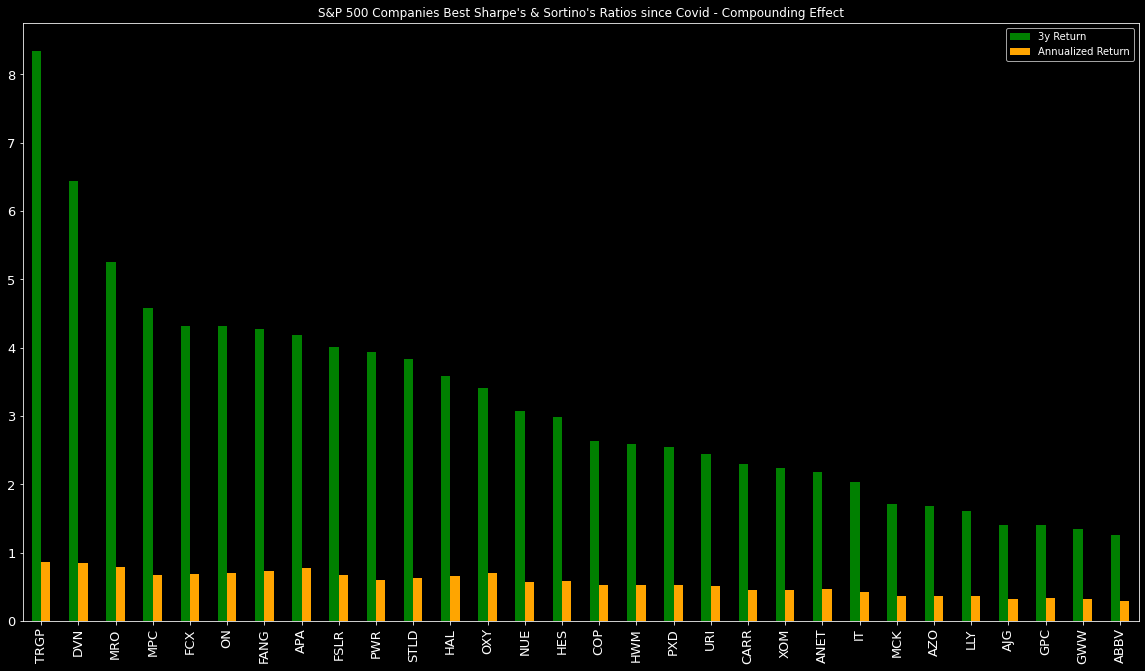

In [190]:
three_years.plot(kind = "bar", figsize = (20, 11), title = "S&P 500 Companies Best Sharpe's & Sortino's Ratios since Covid - Compounding Effect", color = ["green", "orange"], fontsize = 13)

On a monthly basis, the returns of these assets behaved as follows:

In [51]:
#Obtain monthly assets_returns 
assets_prices = adj_daily[assets.index]
assets_returns = returns[assets.index]
assets_returns.index = pd.to_datetime(assets_returns.index)
assets_mreturns=assets_returns.resample('M').sum()
assets_mreturns.head()


,TRGP,PWR,MPC,DVN,MRO,MCK,ON,FCX,FANG,STLD,...,COP,APA,AJG,PXD,GWW,OXY,HWM,URI,GPC,ABBV
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-30,0.438011,0.082971,0.236861,0.343679,0.394671,0.028884,0.114161,0.078276,0.351449,0.055386,...,0.230360,0.527632,-0.092682,0.161230,-0.037507,0.139048,0.097078,0.181627,0.071125,0.002921
2020-05-31,0.360159,0.025165,0.135572,-0.118606,-0.113666,0.126419,0.054398,0.037187,0.007796,0.101701,...,0.022181,-0.155351,0.187927,0.043875,0.126588,-0.217932,0.032169,0.094508,0.061654,0.123594
2020-06-30,0.165653,0.070832,0.081668,0.097699,0.188991,-0.028446,0.198844,0.265479,0.025781,0.006211,...,0.012842,0.287152,0.043494,0.087839,0.018835,0.446881,0.230040,0.086807,0.057726,0.060909
2020-07-31,-0.072936,0.023135,0.033134,-0.061619,-0.094306,-0.018081,0.044889,0.118500,-0.030083,0.054545,...,-0.096900,0.162709,0.098919,-0.001267,0.086615,-0.132100,-0.061204,0.047149,0.037690,-0.020523
2020-08-31,-0.061128,0.253868,-0.051333,0.067945,-0.029829,0.028416,0.041274,0.198597,-0.005964,0.077750,...,0.017450,-0.028956,-0.019778,0.074441,0.072981,-0.200072,0.180027,0.135364,0.047759,0.010197


In [53]:
start = (datetime.datetime.now() - datetime.timedelta(days = 365 * 3)).strftime("%Y-%m-%d") #3 years ago from today's date
end = (datetime.datetime.now()).strftime("%Y-%m-%d") #Today
assets_mreturns.tail()

,TRGP,PWR,MPC,DVN,MRO,MCK,ON,FCX,FANG,STLD,...,COP,APA,AJG,PXD,GWW,OXY,HWM,URI,GPC,ABBV
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-31,-0.006725,-0.047469,-0.041079,-0.080872,-0.117713,-0.015753,-0.180123,-0.042294,-0.074811,-0.053416,...,-0.035080,0.006585,-0.050696,-0.027398,-0.079305,-0.092598,0.047510,0.010039,-0.048817,0.003392
2023-01-31,0.027644,0.069180,0.104112,0.032602,0.019235,0.010476,0.172221,0.169911,0.069529,0.220180,...,0.035539,-0.040018,0.038837,0.011229,0.061487,0.031942,0.034231,0.223309,-0.031849,-0.078545
2023-02-28,-0.009840,0.062861,-0.027994,-0.149087,-0.078385,-0.076684,0.060573,-0.082617,-0.031472,0.048125,...,-0.153666,-0.136793,-0.042438,-0.133144,0.137415,-0.095808,0.038879,0.066744,0.054374,0.041955
2023-03-31,-0.009463,0.034265,0.092488,-0.036608,-0.037380,0.019552,0.071274,0.007506,-0.011170,-0.088869,...,-0.029271,-0.050727,0.026709,0.052785,0.032749,0.072446,0.008535,-0.157271,-0.046040,0.036443
2023-04-30,0.049849,-0.008565,-0.027769,0.089058,0.073743,0.023756,-0.057432,0.054052,0.078195,-0.067323,...,0.099075,0.120185,0.043172,0.112723,-0.061867,0.038221,0.027498,-0.054128,-0.017962,0.029919


As we can appreciate Sortino's ratio maximization emphasizes the importance of minimizing the downside risk of the assets. <br>

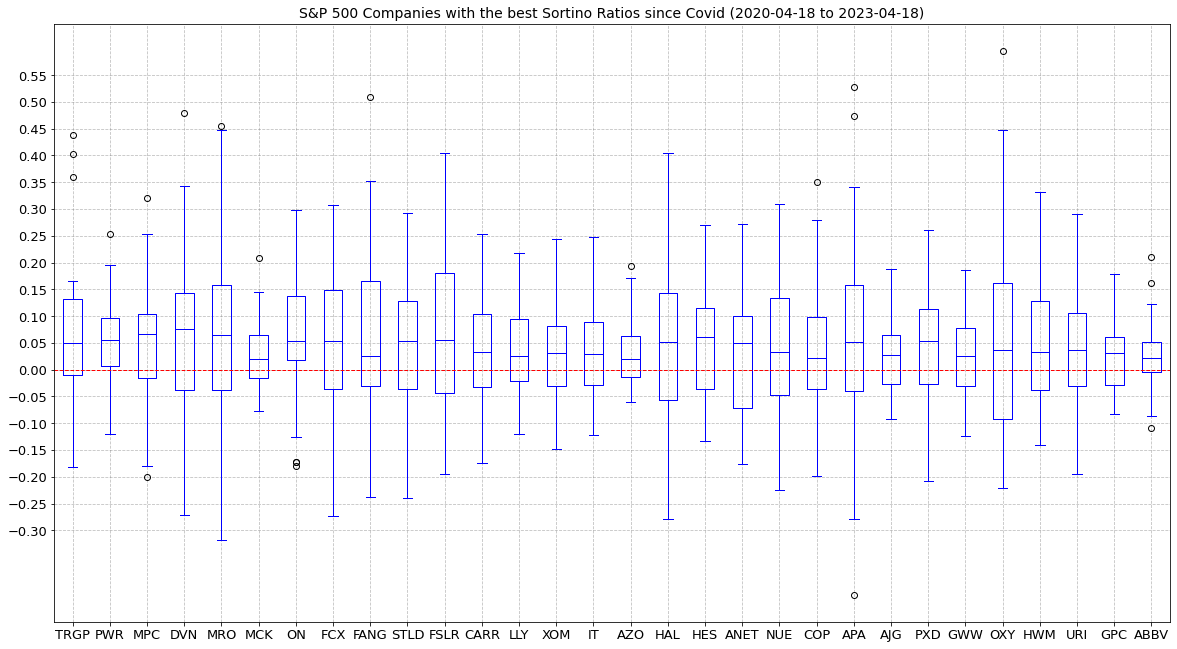

In [50]:
#Statistics for Best S&P 500 Companies with the best Sortino Ratios since Covid.
assets_mreturns.plot(kind = "box", figsize = (20, 11),
                      title = "Best Monthly Returns on S&P 500 Companies with good Sharpe & Sortino Ratios since Covid (" 
                      + str(start) + " to " + str(end) + ")" , color = "blue", fontsize = 13)

#Style
plt.title("S&P 500 Companies with the best Sortino Ratios since Covid (" + str(start) + " to " + str(end) + ")" , fontsize = 14)
plt.axhline(0, color = "red", lw = 1, linestyle = "--")
plt.yticks(np.arange(-0.30, 0.6, 0.05))
plt.grid(alpha = 0.5, linestyle = "--", color = "grey")
plt.show()

A KDE is a non-parametric way to estimate the probability density function of a random variable.

In [ ]:
#Obtain the limits of the data 
min, max = assets_returns[0:5].min(), assets_returns[0:5].max()
x_grid = [np.arange(min[i], max[i], 0.01) for i in range(len(min))]

In [172]:
f_data[0][1], x_grid[0]

,TRGP,PWR,MPC,DVN,MRO,MCK,ON,FCX,FANG,STLD,...,COP,APA,AJG,PXD,GWW,OXY,HWM,URI,GPC,ABBV
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-22,0.012130,0.013433,0.010998,-0.018547,-0.014151,-0.011551,0.010315,0.027619,-0.013696,0.001840,...,-0.003204,0.021459,0.021111,0.016243,0.000594,0.010147,0.050932,0.010289,0.001941,0.005790
2020-06-23,-0.015340,0.007137,0.004921,-0.025197,0.009569,-0.007877,0.030117,0.026877,0.004773,0.000735,...,0.005739,-0.010504,0.008063,0.017455,-0.005640,-0.006027,0.026621,-0.019922,0.007863,0.000411
2020-06-24,-0.069133,-0.039231,-0.066237,-0.091276,-0.085308,-0.020238,-0.044103,-0.046029,-0.095228,-0.050293,...,-0.064369,-0.075018,-0.028097,-0.047540,-0.022190,-0.090450,-0.027926,-0.075010,-0.042628,-0.022300
2020-06-25,0.021967,0.026080,0.012697,0.040000,0.032815,0.004848,0.009850,0.048250,0.041050,0.032083,...,0.026104,0.045142,0.026377,0.060113,0.003935,0.030000,0.039672,0.013410,0.004606,0.019445
2020-06-26,-0.069601,-0.007959,-0.035977,-0.064957,-0.040134,-0.020358,-0.020021,-0.026173,-0.057084,-0.047940,...,-0.040656,-0.030015,-0.006271,-0.036745,-0.009562,-0.045847,0.014474,-0.027297,-0.016459,-0.008867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06,-0.004649,-0.004380,-0.030367,-0.011582,-0.007004,-0.008254,-0.015678,-0.000744,-0.016995,0.002034,...,-0.013828,0.002106,0.010703,-0.010646,-0.007103,-0.023695,-0.013299,0.011387,0.000740,0.004664
2023-04-10,0.006273,0.015145,0.019894,0.009072,0.009404,0.001837,0.031325,-0.003971,0.018783,0.027942,...,-0.002917,0.026793,-0.008917,0.057936,0.015273,0.016656,0.013718,0.027163,0.015405,-0.001671
2023-04-11,0.012202,0.013557,0.007239,0.017044,0.013587,-0.012407,-0.006178,0.024919,0.013828,0.015895,...,0.007551,0.021233,0.006032,0.000772,-0.004697,0.004369,0.012821,0.015428,0.003581,0.000620


In [ ]:
#Plot daily returns with kernel density estimation
assets_returns = assets_returns[0:5].iloc[1:]
f_data = [kde(assets_returns.iloc[:, i], np.arange(0,1.01,0.01), 5, x_grid[i], "KDE: " + str(assets_prices.columns[i]) + "Daily Returns", 100) for i in range(0, len(assets_prices.columns))]
#Gather all histograms in a common plot

In [ ]:
#Make subplots of kde function
fig, axs = plt.subplots(5, 6, figsize = (40, 20))
assets_returns = assets_returns.iloc[1:]
f_data = [kde(assets_returns.iloc[:, i], np.arange(0,1.01,0.01), 5, x_grid[i], ("Daily Returns and KDE" + str(assets_prices.columns[i])), 100) for i in range(0, len(assets_prices.columns))]
#Fill subplots in fig, axs with f_data
for i in range(0, len(assets_prices.columns)):
    axs[i//6, i%6].plot(x_grid[i], f_data[i][1], color = np.random.choice(colors))
    axs[i//6, i%6].hist(assets_returns.iloc[:, i], bins = 100, density = True, color = np.random.choice(colors), edgecolor= 'white', alpha = 0.5)
    axs[i//6, i%6].set_title("Daily Returns and KDE: " + str(assets_prices.columns[i]))
    axs[i//6, i%6].set_xlabel("Daily Returns")
    axs[i//6, i%6].set_ylabel("Frequency")
    axs[i//6, i%6].grid(color='gray', linestyle='--')
    axs[i//6, i%6].set_xticks(np.arange(round(assets_returns.min()[i],3), round(assets_returns.max()[i],3), 0.01))
    axs[i//6, i%6].set_yticks(np.arange(0, f_data[i][1].max()+10, 1))
    axs[i//6, i%6].set_xlim(assets_returns.min()[i], assets_returns.max()[i])
plt.show()
